# Conformal predictive decision making

We tackle the same problem as https://www.alrw.net/articles/19.pdf, using our Nearest neighbours prediction machine

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
from online_cp.CPS import NearestNeighboursPredictionMachine
from sklearn.preprocessing import LabelEncoder
import numpy as np
rnd_gen = np.random.default_rng(2024)
import matplotlib.pyplot as plt
MACHINE_EPSILON = lambda x: np.abs(x) * np.finfo(np.float64).eps
from tqdm.notebook import tqdm

In [2]:
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X_raw = mushroom.data.features 
y_raw = mushroom.data.targets 

X = np.array([LabelEncoder().fit(col).transform(col) for col in X_raw.values.T]).T
y = y_raw.values.reshape(1, -1)[0]

In [3]:
N = 8
X_train = X[:N]
y_train = y[:N]

In [4]:
def U(y, d):
    if y == 'e':
        if d == 'eat':
            util = 1
        if d == 'not eat':
            util = 0
    if y == 'p':
        if d == 'eat':
            util = -10
        if d == 'not eat':
            util = 1
    return util

In [5]:
d = 'eat'
tau = rnd_gen.uniform(0, 1)
U_train_d = np.array([U(y, d) for y in y_train]).astype('float')

cps = NearestNeighboursPredictionMachine(k=3, distance='hamming', rnd_state=2024)
cps.learn_initial_training_set(X_train, U_train_d)
cpd = cps.predict_cpd(X[N])

{'eat': -1.9050951221178458, 'not eat': 0.7106365304665183}
p


'not eat'

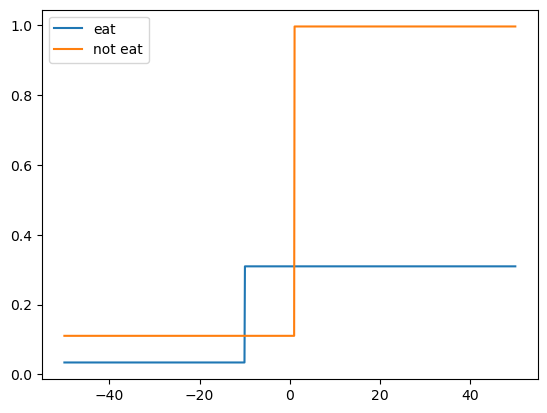

In [6]:
utility = {}
for d in ['eat', 'not eat']:
    tau = rnd_gen.uniform(0, 1)
    U_train_d = np.array([U(y, d) for y in y_train]).astype('float')

    cps = NearestNeighboursPredictionMachine(k=1, distance='hamming', rnd_state=2024)
    cps.learn_initial_training_set(X_train, U_train_d)
    cpd = cps.predict_cpd(X[N])

    jump_points = np.unique(cpd.Y[1:-1])
    Delta_Q = np.array([cpd(y=y + MACHINE_EPSILON(y), tau=tau) - cpd(y=y - MACHINE_EPSILON(y), tau=tau) for y in jump_points])
    utility[d] = jump_points @ Delta_Q

    yrange = np.linspace(-50, 50, num=1000, endpoint=True) 

    tau = rnd_gen.uniform(0, 1)
    plt.plot(
        yrange,
        [cpd(y=y, tau=tau) for y in yrange],
        label=d
    )

print(utility)
print(y[N])

plt.legend()
max(utility, key=utility.get)

# Try the same experimental setup as Vovk and Bendtsen
"We draw 1000 random
balanced training sets for each of a range of sizes ({4, 6, . . . , 20}), evaluating the
performance of the two procedures on each training set using random balanced
test sets of size 10."

It seems that the problem could be that the NearestNeighboursPredictionMachine requires all labels and distances to be distinct. This is a bit of a limitation. Hopefully it can be fixed, but it may take some work...

In [7]:
from copy import deepcopy
df = deepcopy(X_raw)
df['poisonous'] = y_raw.poisonous

In [8]:
# Function to sample a balanced training set
def sample_balanced_training_set_and_encode(df, target_column, n, random_state=None):
    # Ensure N is even
    if n % 2 != 0:
        raise ValueError("N must be an even number to balance classes.")
    
    # Check that both classes have enough samples
    class_counts = df[target_column].value_counts()
    if any(class_counts < n // 2):
        raise ValueError("Not enough samples in one of the classes to create a balanced set.")
    
    # Split the DataFrame by class
    class_0 = df[df[target_column] == 'e']
    class_1 = df[df[target_column] == 'p']
    
    # Sample N/2 from each class
    sample_0 = class_0.sample(n=n // 2, random_state=random_state)  # random_state for reproducibility
    sample_1 = class_1.sample(n=n // 2, random_state=random_state)
    
    # Combine and shuffle the samples
    balanced_sample = pd.concat([sample_0, sample_1]).sample(frac=1, random_state=42).reset_index(drop=True)
    
    X = balanced_sample.drop(columns=[target_column])
    Y = balanced_sample[target_column]

    X = np.array([LabelEncoder().fit(col).transform(col) for col in X.values.T]).T
    Y = Y.values.reshape(1, -1)[0]

    return X, Y

In [ ]:
# runs = 100
# for training_set_size in [4, 6, 8, 10, 12, 14, 16, 18, 20]:
#     TRAINING_SETS = [sample_balanced_training_set_and_encode(df, target_column='poisonous', n=training_set_size, random_state=r) for r in range(runs)]
#     TEST_SETS = [sample_balanced_training_set_and_encode(df, target_column='poisonous', n=10, random_state=r) for r in range(runs)]    
#     util = 0
#     for (X_train, y_train), (X_test, y_test) in zip(TRAINING_SETS, TEST_SETS):
#         for obj, lab in zip(X_test, y_test):
#             utility = {}
#             for d in ['eat', 'not eat']:
#                 tau = rnd_gen.uniform(0, 1)
#                 U_train_d = np.array([U(y, d) for y in y_train]).astype('float')

#                 cps = NearestNeighboursPredictionMachine(k=3, distance='hamming', rnd_state=2024)
#                 cps.learn_initial_training_set(X_train, U_train_d)
#                 cpd = cps.predict_cpd(obj)

#                 jump_points = np.unique(cpd.Y[1:-1])
#                 Delta_Q = np.array([cpd(y=y + MACHINE_EPSILON(y), tau=tau) - cpd(y=y - MACHINE_EPSILON(y), tau=tau) for y in jump_points])
#                 utility[d] = jump_points @ Delta_Q
                
#             decision =  max(utility, key=utility.get)
#             util += utility[decision]

#     print(f'Size: {training_set_size}')
#     print(f'Average utility: {util/(10*runs)}')
    

Size: 4
Average utility: 0.41202039857788225


/tmp/ipykernel_561087/2538654545.py:18: RuntimeWarning: invalid value encountered in scalar add
  Delta_Q = np.array([cpd(y=y + MACHINE_EPSILON(y), tau=tau) - cpd(y=y - MACHINE_EPSILON(y), tau=tau) for y in jump_points])


ValueError: zero-size array to reduction operation maximum which has no identity